# Allianz X Atlassian 2024 Datathon
### Aaron Jeong

## 0. Datathon Description

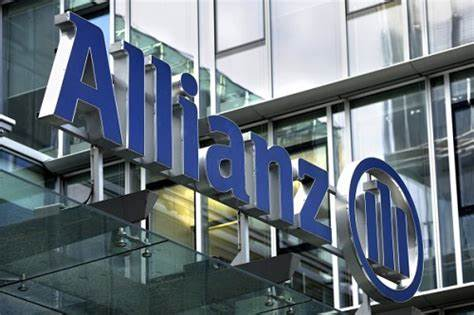

The datathon, organized by Atlassian and Allianz in collaboration with UNSW DataSoc, focused on developing a fraud detection model using insurance claim data. Emphasis was placed not only on predictive accuracy but also on the importance of feature analysis to provide meaningful insights. The event spanned three days, from July 10th to July 12th, 2024, during which our team emerged as one of the finalists.

During the datathon, time constraints led us to apply only Random Forest, XGBoost, and LightGBM with oversampling techniques. This report expands upon our research by incorporating a wider array of methodologies, refined based on feedback from expert panels.

## 1. Exploratory Data Analysis

### 1.0) Preliminaries

For the initial steps, the necessary modules and data required for this research will be imported. Please ensure that your desktop has all these modules installed before running the code. Additionally, verify that the "Fraud.csv" file is located in the same folder as this code.

In [1]:
# Import Modules
!pip install lightgbm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, accuracy_score
import optuna
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from imblearn.metrics.pairwise import ValueDifferenceMetric
from imblearn.over_sampling import SMOTEN
import re

# Import Dataset
file_path = "Fraud_data.csv"
df = pd.read_csv(file_path)

### 1.1) Data Visulizations

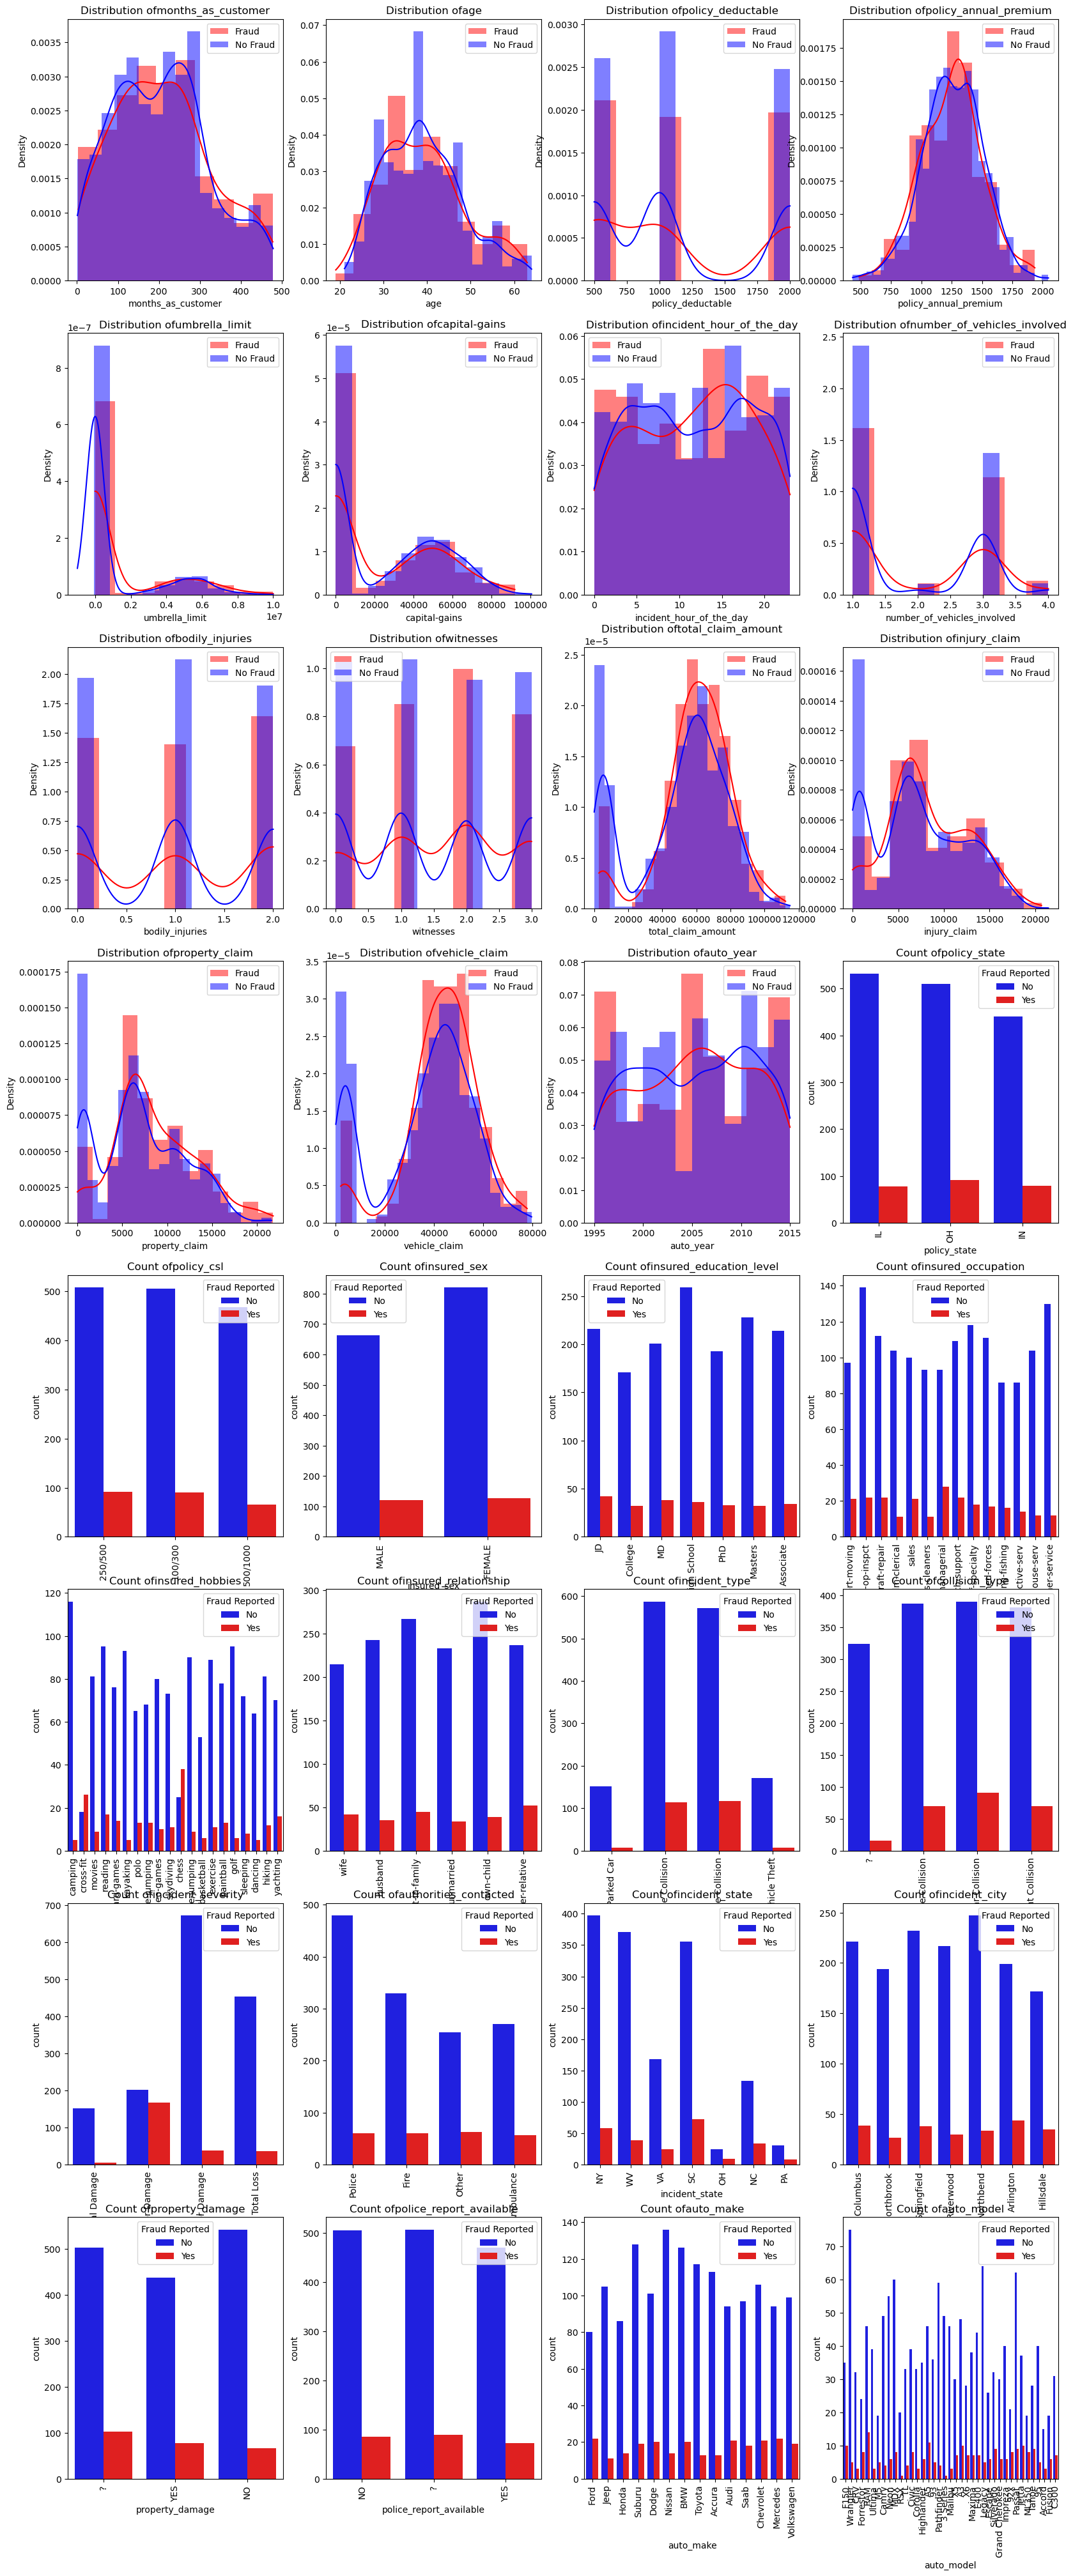

In [2]:
fraud = df[df["fraud_reported"]=="Y"]
nofraud = df[df["fraud_reported"]=="N"]

# Plot numerical features
numerical_features = ['months_as_customer','age','policy_deductable','policy_annual_premium',
                      'umbrella_limit','capital-gains','incident_hour_of_the_day','number_of_vehicles_involved',
                      'bodily_injuries','witnesses','total_claim_amount','injury_claim','property_claim',
                      'vehicle_claim','auto_year']
# Plot categorical features
categorical_features = ['policy_state','policy_csl','insured_sex','insured_education_level','insured_occupation',
                        'insured_hobbies','insured_relationship','incident_type','collision_type',
                        'incident_severity','authorities_contacted','incident_state','incident_city',
                        'property_damage','police_report_available','auto_make','auto_model']

# Create a figure with 10x4 subplots
fig, axes = plt.subplots(8,4, figsize=(20,50))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(fraud[feature], color='red', label='Fraud', kde=True, stat="density", linewidth=0, ax=axes[i])
    sns.histplot(nofraud[feature], color='blue', label='No Fraud', kde=True, stat="density", linewidth=0, ax=axes[i])
    axes[i].set_title(f'Distribution of{feature}')
    axes[i].legend()
for i, feature in enumerate(categorical_features, start=len(numerical_features)):
    sns.countplot(data=df, x=feature, hue='fraud_reported', palette={'Y':'red','N':'blue'}, ax=axes[i])
    axes[i].set_title(f'Count of{feature}')
    axes[i].legend(title='Fraud Reported', labels=['No','Yes'])
    axes[i].tick_params(axis='x', rotation=90)
    
# Hide any unused subplots
for j in range(i+1,len(axes)):
    fig.delaxes(axes[j])
    plt.tight_layout()

plt.show()

As indicated by the figures, certain predictors exhibit zero-inflation, while others display high-cardinality. These characteristics of the dataset may need modification to enhance model performance, as detailed in the forthcoming Modelling sections.

### 1.2) Data Validation and Cleansing

In the dataset, several suspicious entries were identified and modified for ongoing research purposes. Initially, a single row displayed a negative umbrella limit, which was adjusted to the median value of 0. Furthermore, there were 154 instances where the "authorities_contacted" field was null. To address these null values, following approache was employed:

**- Unknown Imputation Approach**: Null values were replaced with "unknown", and the resulting dataset was saved as **df_imputed**.

This adjustment ensures the dataset is suitable for further analysis and modeling in the research process.

In response to Allianz's ethical requirements, a dataset will be generated with careful consideration to remove factors that may pose ethical concerns. This ensures that the predictive model not only achieves high accuracy but also adheres to ethical standards. Using policyholders' characteristics in practices can raise ethical issues related to fairness, discrimination, privacy, transparency, and regulatory compliance. Unfair treatment and adverse selection may occur if characteristics like gender, or hobbies are used, leading to discriminatory practices.



In [3]:
df = df.drop(columns=['_c39'])

# Ethical Column List
ethical = ["insured_zip", "insured_sex", "insured_education_level", 
           "insured_occupation","insured_hobbies", "insured_relationship"]

# Negative Umbrella Limit
df.loc[df["umbrella_limit"] <0,"umbrella_limit"] = df["umbrella_limit"].median()

# Imputation
df['authorities_contacted'] = df['authorities_contacted'].fillna('unknown')

# Ethical Features Data
df_ethical = df.drop(columns=ethical)

## 2. Data Preprocessing

### 2.1) Unbalanced Dataset

As depicted in the data visulaization plots, the fraud data utilized in this research is highly imbalanced. Imbalanced data can degrade model performance by favoring the majority class. To address this issue, oversampling techniques such as the SMOTE-N algorithm will be implemented, as undersampling is disregarded due to the dataset's limited size. It's important to note that oversampling methods can be contentious because they may generate synthetic data that does not accurately represent real-world scenarios.

Alternatively, cost-sensitive learning can be also employed by duplicating data in the minority class to achieve a balanced dataset. This approach aims to mitigate the imbalance and enhance the model's ability to accurately predict fraudulent cases.

In [4]:
# SMOTE-N
X = df.drop(columns=['fraud_reported'])
y = df['fraud_reported']

sampler = SMOTEN(
    sampling_strategy='auto', # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=5,
    n_jobs=4,
)

X_res, y_res = sampler.fit_resample(X, y)
X_res["fraud_reported"] = y_res
df_smote = X_res

X = df_ethical.drop(columns=['fraud_reported'])
y = df_ethical['fraud_reported']
sampler = SMOTEN(
    sampling_strategy='auto', # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=5,
    n_jobs=4,
)

X_res, y_res = sampler.fit_resample(X, y)
X_res["fraud_reported"] = y_res
df_ethical_smote = X_res

# Cost-Sensitive
df_cost = df.copy()
df_cost = pd.concat([df_cost,df[df["fraud_reported"] == "Y"]] , ignore_index=True)
df_cost = pd.concat([df_cost,df[df["fraud_reported"] == "Y"]] , ignore_index=True)
df_cost = pd.concat([df_cost,df[df["fraud_reported"] == "Y"]] , ignore_index=True)
df_cost = pd.concat([df_cost,df[df["fraud_reported"] == "Y"]] , ignore_index=True)
df_cost = pd.concat([df_cost,df[df["fraud_reported"] == "Y"]] , ignore_index=True)

df_ethical_cost = df_ethical.copy()
df_ethicalcost = pd.concat([df_ethical_cost,df_ethical[df_ethical["fraud_reported"] == "Y"]] , ignore_index=True)
df_ethicalcost = pd.concat([df_ethical_cost,df_ethical[df_ethical["fraud_reported"] == "Y"]] , ignore_index=True)
df_ethicalcost = pd.concat([df_ethical_cost,df_ethical[df_ethical["fraud_reported"] == "Y"]] , ignore_index=True)
df_ethicalcost = pd.concat([df_ethical_cost,df_ethical[df_ethical["fraud_reported"] == "Y"]] , ignore_index=True)
df_ethicalcost = pd.concat([df_ethical_cost,df_ethical[df_ethical["fraud_reported"] == "Y"]] , ignore_index=True)

/Users/jeong-ilseung/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:992: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/jeong-ilseung/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:992: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


### 2.2) Data Encoding and Standardization

In preparation for modelling, categorical and ordinal data will be encoded. Additionally, standardization will be applied to ensure uniformity and optimal performance of the models.

In [5]:
def encode_1(df):
    d = df.copy()
    d['policy_bind_date'] = pd.to_datetime(d['policy_bind_date'])
    d['year_bind'] = d['policy_bind_date'].dt.year
    d['month_bind'] = d['policy_bind_date'].dt.month
    d['date_bind'] = d['policy_bind_date'].dt.day
    d['day_of_week_bind'] = d['policy_bind_date'].dt.dayofweek  # Monday=0, Sunday=6

    # Map day_of_week to actual day names
    d['day_of_week_bind'] = d['policy_bind_date'].dt.day_name()

    # Create a column indicating weekend (Saturday or Sunday)
    d['is_weekend_bind'] = d['policy_bind_date'].dt.dayofweek.isin([5, 6]).astype(int)
    d = d.drop(columns=['policy_bind_date'])
    
    # Policy State
    d = pd.get_dummies(d, columns=['policy_state'], prefix='policy_state')

    # Policy csl
    d = pd.get_dummies(d, columns=['policy_csl'], prefix='policy_csl')

    # Umbrella limit
    d['umbrella_limit_indicator'] = (d['umbrella_limit'] != 0).astype(int)



    # capital-gain
    d['capital-gain_indicator'] = (d['capital-gains'] != 0).astype(int)

    #incident_date
    # Convert 'policy_bind_date' to datetime type
    d['incident_date'] = pd.to_datetime(d['incident_date'])

    # Extract year, month, date, and day of the week
    d['year_incident'] = d['incident_date'].dt.year
    d['month_incident'] = d['incident_date'].dt.month
    d['date_incident'] = d['incident_date'].dt.day
    d['day_of_week_incident'] = d['incident_date'].dt.dayofweek  # Monday=0, Sunday=6

    # Map day_of_week to actual day names
    d['day_of_week_incident'] = d['incident_date'].dt.day_name()

    # Create a column indicating weekend (Saturday or Sunday)
    d['is_weekend_incident'] = d['incident_date'].dt.dayofweek.isin([5, 6]).astype(int)
    d = d.drop(columns=['incident_date'])


    #incident_type
    d = pd.get_dummies(d, columns=['incident_type'], prefix='incident')


    # Collision_type
    d = pd.get_dummies(d, columns=['collision_type'], prefix='collision')


    # incident_severity
    ordinal_mapping = {'Trivial Damage': 1, 'Minor Damage': 2, 'Major Damage': 3, "Total Loss" : 4}
    d['incident_severity'] = d['incident_severity'].map(ordinal_mapping)

    # authorities_contacted
    d = pd.get_dummies(d, columns=['authorities_contacted'], prefix='auth')


    # incident State
    d = pd.get_dummies(d, columns=['incident_state'], prefix='incident_state')


    # incident city
    d = pd.get_dummies(d, columns=['incident_city'], prefix='incident_city')


    # incident_location
    d = d.drop(columns=['incident_location'])

    # Property damage
    d = pd.get_dummies(d, columns=['property_damage'], prefix='property_damge')


    # Police_report_available
    d = pd.get_dummies(d, columns=['police_report_available'], prefix='police')


    # total_claim_amount
    d['total_claim_amount_indicator'] = (d['total_claim_amount'] >= 20000).astype(int)
    d['injury_claim_amount_indicator'] = (d['injury_claim'] >= 3000).astype(int)
    d['property_claim_amount_indicator'] = (d['property_claim'] >= 3000).astype(int)
    d['vehicle_claim_amount_indicator'] = (d['vehicle_claim'] >= 10000).astype(int)

    #Auto
    d = pd.get_dummies(d, columns=['auto_make'], prefix='make')

    d = pd.get_dummies(d, columns=['auto_model'], prefix='auto_model')


    # Fraud
    d['fraud_reported'] = d['fraud_reported'].replace({'Y': 1, 'N': 0})
    d = d.drop(columns=['day_of_week_bind','day_of_week_incident'])
    
    return d

In [6]:
def encode_2(df):
    d = df.copy()
    d['policy_bind_date'] = pd.to_datetime(d['policy_bind_date'])
    d['year_bind'] = d['policy_bind_date'].dt.year
    d['month_bind'] = d['policy_bind_date'].dt.month
    d['date_bind'] = d['policy_bind_date'].dt.day
    d['day_of_week_bind'] = d['policy_bind_date'].dt.dayofweek  # Monday=0, Sunday=6

    # Map day_of_week to actual day names
    d['day_of_week_bind'] = d['policy_bind_date'].dt.day_name()

    # Create a column indicating weekend (Saturday or Sunday)
    d['is_weekend_bind'] = d['policy_bind_date'].dt.dayofweek.isin([5, 6]).astype(int)
    d = d.drop(columns=['policy_bind_date'])
    
    # Policy State
    d = pd.get_dummies(d, columns=['policy_state'], prefix='policy_state')

    # Policy csl
    d = pd.get_dummies(d, columns=['policy_csl'], prefix='policy_csl')

    # Umbrella limit
    d['umbrella_limit_indicator'] = (d['umbrella_limit'] != 0).astype(int)



    # capital-gain
    d['capital-gain_indicator'] = (d['capital-gains'] != 0).astype(int)

    #incident_date
    # Convert 'policy_bind_date' to datetime type
    d['incident_date'] = pd.to_datetime(d['incident_date'])

    # Extract year, month, date, and day of the week
    d['year_incident'] = d['incident_date'].dt.year
    d['month_incident'] = d['incident_date'].dt.month
    d['date_incident'] = d['incident_date'].dt.day
    d['day_of_week_incident'] = d['incident_date'].dt.dayofweek  # Monday=0, Sunday=6

    # Map day_of_week to actual day names
    d['day_of_week_incident'] = d['incident_date'].dt.day_name()

    # Create a column indicating weekend (Saturday or Sunday)
    d['is_weekend_incident'] = d['incident_date'].dt.dayofweek.isin([5, 6]).astype(int)
    d = d.drop(columns=['incident_date'])


    #incident_type
    d = pd.get_dummies(d, columns=['incident_type'], prefix='incident')


    # Collision_type
    d = pd.get_dummies(d, columns=['collision_type'], prefix='collision')


    # incident_severity
    ordinal_mapping = {'Trivial Damage': 1, 'Minor Damage': 2, 'Major Damage': 3, "Total Loss" : 4}
    d['incident_severity'] = d['incident_severity'].map(ordinal_mapping)

    # authorities_contacted
    d = pd.get_dummies(d, columns=['authorities_contacted'], prefix='auth')


    # incident State
    d = pd.get_dummies(d, columns=['incident_state'], prefix='incident_state')


    # incident city
    d = pd.get_dummies(d, columns=['incident_city'], prefix='incident_city')


    # incident_location
    d = d.drop(columns=['incident_location'])

    # Property damage
    d = pd.get_dummies(d, columns=['property_damage'], prefix='property_damge')


    # Police_report_available
    d = pd.get_dummies(d, columns=['police_report_available'], prefix='police')


    # total_claim_amount
    d['total_claim_amount_indicator'] = (d['total_claim_amount'] >= 20000).astype(int)
    d['injury_claim_amount_indicator'] = (d['injury_claim'] >= 3000).astype(int)
    d['property_claim_amount_indicator'] = (d['property_claim'] >= 3000).astype(int)
    d['vehicle_claim_amount_indicator'] = (d['vehicle_claim'] >= 10000).astype(int)

    #Auto
    d = pd.get_dummies(d, columns=['auto_make'], prefix='make')

    d = pd.get_dummies(d, columns=['auto_model'], prefix='auto_model')


    # Fraud
    d['fraud_reported'] = d['fraud_reported'].replace({'Y': 1, 'N': 0})
    
    # insured_sex
    d = d.drop(columns=['insured_sex'])

    # insured_education_level
    d = d.drop(columns=['insured_education_level'])

    # insured_occupation
    d = d.drop(columns=['insured_occupation'])

    # insured_hobbies
    d = d.drop(columns=['insured_hobbies'])

    #insured_relationship
    d = d.drop(columns=['insured_relationship'])
        
    # Group by insured_zip and count occurrences
    frequency = d.groupby('insured_zip').size().reset_index(name='frequency_zip')

    # Merge the frequency column back to the original dataframe
    d = pd.merge(d, frequency, on='insured_zip', how='left')
    d = d.drop(columns=['day_of_week_bind','day_of_week_incident','insured_zip'])
    
    return d

In [7]:
df_smote = encode_2(df_smote)
df_ethical_smote = encode_1(df_ethical_smote)
df_cost = encode_2(df_cost)
df_ethical_cost = encode_1(df_ethical_cost)

df_smote.columns = df_smote.columns.str.strip()
df_smote = pd.DataFrame(df_smote)
df_smote = df_smote.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


df_ethical_smote.columns = df_ethical_smote.columns.str.strip()
df_ethical_smote = pd.DataFrame(df_ethical_smote)
df_ethical_smote = df_ethical_smote.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


df_cost.columns = df_cost.columns.str.strip()
df_cost = pd.DataFrame(df_cost)
df_cost = df_cost.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


df_ethical_cost.columns = df_ethical_cost.columns.str.strip()
df_ethical_cost = pd.DataFrame(df_ethical_cost)
df_ethical_cost = df_ethical_cost.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

### 2.3) Data Splitting

The data will be split randomly into two parts: training and testing datasets, with a ratio of 80% for training data and 20% for testing data. This ensures that the model is trained on a majority of the data while reserving a portion for evaluating its performance on unseen data.

In [15]:
X1 = df_smote.drop(columns=["fraud_reported"])  # Replace "target_column" with the name of your target variable
y1 = df_smote["fraud_reported"]
X1 = X1.drop(columns=['Unnamed0'])
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

X2 = df_ethical_smote.drop(columns=["fraud_reported"])  # Replace "target_column" with the name of your target variable
y2 = df_ethical_smote["fraud_reported"]
X2 = X2.drop(columns=['Unnamed0'])
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

X3 = df_cost.drop(columns=["fraud_reported"])  # Replace "target_column" with the name of your target variable
y3 = df_cost["fraud_reported"]
X3 = X3.drop(columns=['Unnamed0'])
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

X4 = df_ethical_cost.drop(columns=["fraud_reported"])  # Replace "target_column" with the name of your target variable
y4 = df_ethical_cost["fraud_reported"]
X4 = X4.drop(columns=['Unnamed0'])
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)

## 3. Modelling and Training

For our model, we utilized Random Forest, XGBoost, and LightGBM, algorithms. Generalized Linear Models (GLMs) were excluded due to the failure of necessary assumptions in this context. Neural Network (NN) algorithms were also excluded as the size of data given was relatively small to train NN algorithms.

In evaluating the performance of our models, we will consider the R-squared (R²) scores and accuracy metrics. These performance measures will provide insights into how well each model fits the data and its predictive accuracy.

### 3.1) Random Forest

The hyperparameters for random forests were optimized using the Optima module under different conditions:

- **rf1_best**: Tuned using SMOTE-N data.
- **rf2_best**: Tuned using SMOTE-N data, incorporating ethical considerations.
- **rf3_best**: Tuned using a cost-sensitive data.
- **rf4_best**: Tuned using a cost-sensitive data, incorporating ethical considerations.

Each configuration was carefully adjusted to achieve optimal performance in its respective scenario (see Appendix 6.1. for detailed code).

In [16]:
rf1_best = {'n_estimators': 156,
            'max_depth': 115,
            'min_samples_split': 3,
            'min_samples_leaf': 1}

rf2_best = {'n_estimators': 88,
            'max_depth': 190,
            'min_samples_split': 2,
            'min_samples_leaf': 1}

rf3_best = {'n_estimators': 299,
            'max_depth': 65,
            'min_samples_split': 2,
            'min_samples_leaf': 1}

rf4_best = {'n_estimators': 207,
            'max_depth': 185,
            'min_samples_split': 3,
            'min_samples_leaf': 2}

### 3.2) XGBoost

The hyperparameters for XGboost were optimized using the Optima module under different conditions:

- **xgb1_best**: Tuned using SMOTE-N data.
- **xgb2_best**: Tuned using SMOTE-N data, incorporating ethical considerations.
- **xgb3_best**: Tuned using a cost-sensitive data.
- **xgb4_best**: Tuned using a cost-sensitive data, incorporating ethical considerations.

Each configuration was carefully adjusted to achieve optimal performance in its respective scenario (see Appendix 6.2. for detailed code).

In [17]:
xgb1_best = {'max_depth': 38,
             'lambda': 0.9842098482529993,
             'alpha': 0.47705290629269376,
             'subsample': 0.9832392695413226,
             'learning_rate': 0.18984920644064396,
             'colsample_bytree': 0.5128387105691137,
             'n_estimators': 97}

xgb2_best = {'max_depth': 172,
             'lambda': 1.5529052879981236,
             'alpha': 0.1802547467296067,
             'subsample': 0.5453689918640144,
             'learning_rate': 0.12878782871065325,
             'colsample_bytree': 0.7717368208584642,
             'n_estimators': 193}

xgb3_best = {'max_depth': 224,
             'lambda': 1.5087141725418494,
             'alpha': 0.0027059871811653223,
             'subsample': 0.7730280040828572,
             'learning_rate': 0.6426456213726767,
             'colsample_bytree': 0.9948052703622519,
             'n_estimators': 175}

xgb4_best = {'max_depth': 234,
             'lambda': 0.342839818542077,
             'alpha': 0.22566692964251545,
             'subsample': 0.8238140379810838,
             'learning_rate': 0.1334314125436725,
             'colsample_bytree': 0.8206796912460543,
             'n_estimators': 279}

### 3.3) LightGBM

The hyperparameters for lightGBMs were optimized using the Optima module under different conditions:

- **lgb1_best**: Tuned using SMOTE-N data.
- **lgb2_best**: Tuned using SMOTE-N data, incorporating ethical considerations.
- **lgb3_best**: Tuned using a cost-sensitive data.
- **lgb4_best**: Tuned using a cost-sensitive data, incorporating ethical considerations.

Each configuration was carefully adjusted to achieve optimal performance in its respective scenario (see Appendix 6.3. for detailed code).

In [18]:
lgb1_best = {'max_depth': 171,
             'reg_lambda': 0.0001907945126185956,
             'reg_alpha': 4.264841865157855e-06,
             'subsample': 0.9988745106669887,
             'learning_rate': 0.04048614172414351,
             'colsample_bytree': 0.5136162404869287,
             'n_estimators': 274,
             'num_leaves': 107,
             'min_child_samples': 46}

lgb2_best = {'max_depth': 99,
             'reg_lambda': 9.625523319164092,
             'reg_alpha': 0.1999359844263633,
             'subsample': 0.1289601093595202,
             'learning_rate': 0.08355524686784663,
             'colsample_bytree': 0.236527608032113,
             'n_estimators': 259,
             'num_leaves': 83,
             'min_child_samples': 18}

lgb3_best = {'max_depth': 92,
             'reg_lambda': 2.1146158162777094e-08,
             'reg_alpha': 0.0002944576682604421,
             'subsample': 0.9874811396954303,
             'learning_rate': 0.1688110350552917,
             'colsample_bytree': 0.822237844093365,
             'n_estimators': 165,
             'num_leaves': 25,
             'min_child_samples': 7}

lgb4_best = {'max_depth': 90,
             'reg_lambda': 0.02042695584494358,
             'reg_alpha': 0.00012032676285560167,
             'subsample': 0.9561649943320599,
             'learning_rate': 0.06905784962198458,
             'colsample_bytree': 0.46980180502087154,
             'n_estimators': 288,
             'num_leaves': 111,
             'min_child_samples': 8}

## 4. Performances and Feature Importances

The performance of each model was evaluated using R² scores and accuracy metrics:

- **R² Scores**: Provide detailed precision regarding the accuracy of predicted probabilities.
- **Accuracy**: Represents the precision of classification, with a threshold set at 0.5.

These metrics together offer a comprehensive view of the model's performance.

In [19]:
rf = RandomForestRegressor(**rf1_best)
rf = rf.fit(X1_train, y1_train.values.ravel())
y1_pred_rf = rf.predict(X1_test)

rf = RandomForestRegressor(**rf2_best)
rf = rf.fit(X2_train, y2_train.values.ravel())
y2_pred_rf = rf.predict(X2_test)

rf = RandomForestRegressor(**rf3_best)
rf = rf.fit(X3_train, y3_train.values.ravel())
y3_pred_rf = rf.predict(X3_test)

rf = RandomForestRegressor(**rf4_best)
rf = rf.fit(X4_train, y4_train.values.ravel())
y4_pred_rf = rf.predict(X4_test)


xg_reg = XGBRegressor(**xgb1_best)
xg_reg.fit(X1_train,y1_train)
y1_pred_xgb = xg_reg.predict(X1_test)

xg_reg = XGBRegressor(**xgb2_best)
xg_reg.fit(X2_train,y2_train)
y2_pred_xgb = xg_reg.predict(X2_test)

xg_reg = XGBRegressor(**xgb3_best)
xg_reg.fit(X3_train,y3_train)
y3_pred_xgb = xg_reg.predict(X3_test)

xg_reg = XGBRegressor(**xgb4_best)
xg_reg.fit(X4_train,y4_train)
y4_pred_xgb = xg_reg.predict(X4_test)


lgb_reg = LGBMRegressor(**lgb1_best)
lgb_reg.fit(X1_train,y1_train)
y1_pred_lgb = lgb_reg.predict(X1_test)

lgb_reg = LGBMRegressor(**lgb2_best)
lgb_reg.fit(X2_train,y2_train)
y2_pred_lgb = lgb_reg.predict(X2_test)

lgb_reg = LGBMRegressor(**lgb3_best)
lgb_reg.fit(X3_train,y3_train)
y3_pred_lgb = lgb_reg.predict(X3_test)

lgb_reg = LGBMRegressor(**lgb4_best)
lgb_reg.fit(X4_train,y4_train)
y4_pred_lgb = lgb_reg.predict(X4_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2665
[LightGBM] [Info] Number of data points in the train set: 2371, number of used features: 107
[LightGBM] [Info] Start training from score 0.504850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [20]:
print("R2 of RF1", r2_score(y1_test, y1_pred_rf))
print("R2 of xgb1", r2_score(y1_test, y1_pred_xgb))
print("R2 of lgbm1", r2_score(y1_test, y1_pred_lgb))

print("R2 of RF2", r2_score(y2_test, y2_pred_rf))
print("R2 of xgb2", r2_score(y2_test, y2_pred_xgb))
print("R2 of lgbm2", r2_score(y2_test, y2_pred_lgb))

print("R2 of RF3", r2_score(y3_test, y3_pred_rf))
print("R2 of xgb3", r2_score(y3_test, y3_pred_xgb))
print("R2 of lgbm3", r2_score(y3_test, y3_pred_lgb))

print("R2 of RF4", r2_score(y4_test, y4_pred_rf))
print("R2 of xgb4", r2_score(y4_test, y4_pred_xgb))
print("R2 of lgbm4", r2_score(y4_test, y4_pred_lgb))

R2 of RF1 0.8602101856020441
R2 of xgb1 0.8567230738055146
R2 of lgbm1 0.8543143478959606
R2 of RF2 0.8035820586637518
R2 of xgb2 0.8156219266670499
R2 of lgbm2 0.8224125377999032
R2 of RF3 0.9998863512727422
R2 of xgb3 0.9999970655048739
R2 of lgbm3 0.9973080817347922
R2 of RF4 0.36086995541538236
R2 of xgb4 0.4104526883448435
R2 of lgbm4 0.35879046597557107


In [21]:
print("Accuracy of RF1", accuracy_score(y1_test, [int(i>=0.5) for i in y1_pred_rf]))
print("Accuracy of xgb1", accuracy_score(y1_test, [int(i>=0.5) for i in y1_pred_xgb]))
print("Accuracy of lgbm1", accuracy_score(y1_test, [int(i>=0.5) for i in y1_pred_lgb]))

print("Accuracy of RF2", accuracy_score(y2_test, [int(i>=0.5) for i in y2_pred_rf]))
print("Accuracy of xgb2", accuracy_score(y2_test, [int(i>=0.5) for i in y2_pred_xgb]))
print("Accuracy of lgbm2", accuracy_score(y2_test, [int(i>=0.5) for i in y2_pred_lgb]))

print("Accuracy of RF3", accuracy_score(y3_test, [int(i>=0.5) for i in y3_pred_rf]))
print("Accuracy of xgb3", accuracy_score(y3_test, [int(i>=0.5) for i in y3_pred_xgb]))
print("Accuracy of lgbm3", accuracy_score(y3_test, [int(i>=0.5) for i in y3_pred_lgb]))

print("Accuracy of RF4", accuracy_score(y4_test, [int(i>=0.5) for i in y4_pred_rf]))
print("Accuracy of xgb4", accuracy_score(y4_test, [int(i>=0.5) for i in y4_pred_xgb]))
print("Accuracy of lgbm4", accuracy_score(y4_test, [int(i>=0.5) for i in y4_pred_lgb]))

Accuracy of RF1 0.9561551433389545
Accuracy of xgb1 0.9510961214165261
Accuracy of lgbm1 0.9561551433389545
Accuracy of RF2 0.9342327150084317
Accuracy of xgb2 0.9376053962900506
Accuracy of lgbm2 0.9376053962900506
Accuracy of RF3 1.0
Accuracy of xgb3 1.0
Accuracy of lgbm3 1.0
Accuracy of RF4 0.8988439306358381
Accuracy of xgb4 0.8930635838150289
Accuracy of lgbm4 0.8872832369942196


## 5. Conclusion

As demonstrated by the performance metrics, models without ethical considerations consistently outperformed those with ethical considerations across all models. This disparity is understandable, as certain features were excluded when addressing ethical concerns. Additionally, it is noteworthy that in the absence of ethical considerations, the cost-sensitive oversampling method proved superior to SMOTE-N oversampling. However, with ethical considerations in place, SMOTE-N oversampling outperformed the cost-sensitive method. When using the same dataset, the performance differences among the various models were not significant. To gain a deeper understanding of how each feature influences fraud probabilities, analyzing feature importance would be beneficial. Furthermore, as the dataset size increases, exploring neural network algorithms should also be considered.


## 6. Appendix

### 6.1. Hyperparameters Tuning for Random Forests

In [9]:
'''
#Hyperparameter Tuning for X1,y1
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators',10,300),
        'max_depth': trial.suggest_int('max_depth',10,200),
        'min_samples_split': trial.suggest_int('min_samples_split',2,50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,30),
    }

    skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = RandomForestRegressor(**params)

    error = cross_val_score(model, X1_train, y1_train, cv=skf, scoring='r2').mean()

    return error

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)
rf1_best = study.best_params

#Hyperparameter Tuning for X2,y2
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators',10,300),
        'max_depth': trial.suggest_int('max_depth',10,200),
        'min_samples_split': trial.suggest_int('min_samples_split',2,50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,30),
    }

    skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = RandomForestRegressor(**params)

    error = cross_val_score(model, X2_train, y2_train, cv=skf, scoring='r2').mean()

    return error

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)
rf2_best = study.best_params

#Hyperparameter Tuning for X3,y3
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators',10,300),
        'max_depth': trial.suggest_int('max_depth',10,200),
        'min_samples_split': trial.suggest_int('min_samples_split',2,50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,30),
    }

    skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = RandomForestRegressor(**params)

    error = cross_val_score(model, X3_train, y3_train, cv=skf, scoring='r2').mean()

    return error

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)
rf3_best = study.best_params

#Hyperparameter Tuning for X4,y4
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators',10,300),
        'max_depth': trial.suggest_int('max_depth',10,200),
        'min_samples_split': trial.suggest_int('min_samples_split',2,50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,30),
    }

    skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = RandomForestRegressor(**params)

    error = cross_val_score(model, X4_train, y4_train, cv=skf, scoring='r2').mean()

    return error

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)
rf4_best = study.best_params
'''

'\n#Hyperparameter Tuning for X1,y1\ndef objective(trial):\n    params = {\n        \'n_estimators\': trial.suggest_int(\'n_estimators\',10,300),\n        \'max_depth\': trial.suggest_int(\'max_depth\',10,200),\n        \'min_samples_split\': trial.suggest_int(\'min_samples_split\',2,50),\n        \'min_samples_leaf\': trial.suggest_int(\'min_samples_leaf\',1,30),\n    }\n\n    skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n    model = RandomForestRegressor(**params)\n\n    error = cross_val_score(model, X1_train, y1_train, cv=skf, scoring=\'r2\').mean()\n\n    return error\n\nstudy = optuna.create_study(direction="maximize")\nstudy.optimize(objective, n_trials=100, show_progress_bar=True)\nrf1_best = study.best_params\n\n#Hyperparameter Tuning for X2,y2\ndef objective(trial):\n    params = {\n        \'n_estimators\': trial.suggest_int(\'n_estimators\',10,300),\n        \'max_depth\': trial.suggest_int(\'max_depth\',10,200),\n        \'min_samples_split\': trial.su

### 6.2. Hyperparameter Tuning for XGBoosts

In [10]:
'''
#Hyperparameter Tuning for X1,y1
def objective(trial):
    params = {
        'objective' : 'binary:logistic',
        'verbosity': 0,
        'max_depth': trial.suggest_int('max_depth',5,300),
        'random_state': 42,
        'lambda': trial.suggest_float('lambda', 0.0, 3.0),
        'alpha': trial.suggest_float('alpha', 0.0, 3.0),
        'subsample': trial.suggest_float('subsample', 0.0, 1.0),
        'objective': 'reg:squaredlogerror',
        'learning_rate': trial.suggest_float('learning_rate', 0.0, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators',10,300)
    }

    skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = XGBRegressor(**params)

    error = cross_val_score(model, X1_train, y1_train, cv=skf, scoring='r2').mean()

    return error

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)
xgb1_best = study.best_params

#Hyperparameter Tuning for X2,y2
def objective(trial):
    params = {
        'objective' : 'binary:logistic',
        'verbosity': 0,
        'max_depth': trial.suggest_int('max_depth',5,300),
        'random_state': 42,
        'lambda': trial.suggest_float('lambda', 0.0, 3.0),
        'alpha': trial.suggest_float('alpha', 0.0, 3.0),
        'subsample': trial.suggest_float('subsample', 0.0, 1.0),
        'objective': 'reg:squaredlogerror',
        'learning_rate': trial.suggest_float('learning_rate', 0.0, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators',10,300)
    }

    skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = XGBRegressor(**params)

    error = cross_val_score(model, X2_train, y2_train, cv=skf, scoring='r2').mean()

    return error

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)
xgb2_best = study.best_params

#Hyperparameter Tuning for X3,y3
def objective(trial):
    params = {
        'objective' : 'binary:logistic',
        'verbosity': 0,
        'max_depth': trial.suggest_int('max_depth',5,300),
        'random_state': 42,
        'lambda': trial.suggest_float('lambda', 0.0, 3.0),
        'alpha': trial.suggest_float('alpha', 0.0, 3.0),
        'subsample': trial.suggest_float('subsample', 0.0, 1.0),
        'objective': 'reg:squaredlogerror',
        'learning_rate': trial.suggest_float('learning_rate', 0.0, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators',10,300)
    }

    skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = XGBRegressor(**params)

    error = cross_val_score(model, X3_train, y3_train, cv=skf, scoring='r2').mean()

    return error

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)
xgb3_best = study.best_params

#Hyperparameter Tuning for X4,y4
def objective(trial):
    params = {
        'objective' : 'binary:logistic',
        'verbosity': 0,
        'max_depth': trial.suggest_int('max_depth',5,300),
        'random_state': 42,
        'lambda': trial.suggest_float('lambda', 0.0, 3.0),
        'alpha': trial.suggest_float('alpha', 0.0, 3.0),
        'subsample': trial.suggest_float('subsample', 0.0, 1.0),
        'objective': 'reg:squaredlogerror',
        'learning_rate': trial.suggest_float('learning_rate', 0.0, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators',10,300)
    }

    skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = XGBRegressor(**params)

    error = cross_val_score(model, X4_train, y4_train, cv=skf, scoring='r2').mean()

    return error

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)
xgb4_best = study.best_params
print(study.best_value)
print(xgb4_best)
'''

'\n#Hyperparameter Tuning for X1,y1\ndef objective(trial):\n    params = {\n        \'objective\' : \'binary:logistic\',\n        \'verbosity\': 0,\n        \'max_depth\': trial.suggest_int(\'max_depth\',5,300),\n        \'random_state\': 42,\n        \'lambda\': trial.suggest_float(\'lambda\', 0.0, 3.0),\n        \'alpha\': trial.suggest_float(\'alpha\', 0.0, 3.0),\n        \'subsample\': trial.suggest_float(\'subsample\', 0.0, 1.0),\n        \'objective\': \'reg:squaredlogerror\',\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.0, 1.0),\n        \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.0, 1.0),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\',10,300)\n    }\n\n    skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n    model = XGBRegressor(**params)\n\n    error = cross_val_score(model, X1_train, y1_train, cv=skf, scoring=\'r2\').mean()\n\n    return error\n\nstudy = optuna.create_study(direction="maximize")\ns

### 6.3. Hyperparameter Tuning for LightGBMs

In [11]:
'''
#Hyperparameter Tuning for X1,y1
def objective(trial):
    params = {
        'objective' : 'binary',
        'verbosity': -1,
        'max_depth': trial.suggest_int('max_depth',5,300),
        'random_state': 42,
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.0, 1.0),
        'objective': 'regression',
        'learning_rate': trial.suggest_float('learning_rate', 1e-9, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators',10,300),
        'boosting_type':'gbdt',
        'num_leaves': trial.suggest_int('num_leaves',20,300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = LGBMRegressor(**params)

    error = cross_val_score(model, X1_train, y1_train, cv=skf, scoring='r2').mean()

    return error

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)
lgb1_best = study.best_params

#Hyperparameter Tuning for X2,y2
def objective(trial):
    params = {
        'objective' : 'binary',
        'verbosity': -1,
        'max_depth': trial.suggest_int('max_depth',5,300),
        'random_state': 42,
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.0, 1.0),
        'objective': 'regression',
        'learning_rate': trial.suggest_float('learning_rate', 1e-9, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators',10,300),
        'boosting_type':'gbdt',
        'num_leaves': trial.suggest_int('num_leaves',20,300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = LGBMRegressor(**params)

    error = cross_val_score(model, X2_train, y2_train, cv=skf, scoring='r2').mean()

    return error

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)
lgb2_best = study.best_params

#Hyperparameter Tuning for X3,y3
def objective(trial):
    params = {
        'objective' : 'binary',
        'verbosity': -1,
        'max_depth': trial.suggest_int('max_depth',5,300),
        'random_state': 42,
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.0, 1.0),
        'objective': 'regression',
        'learning_rate': trial.suggest_float('learning_rate', 1e-9, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators',10,300),
        'boosting_type':'gbdt',
        'num_leaves': trial.suggest_int('num_leaves',20,300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = LGBMRegressor(**params)

    error = cross_val_score(model, X3_train, y3_train, cv=skf, scoring='r2').mean()

    return error

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)
lgb3_best = study.best_params

#Hyperparameter Tuning for X4,y4
def objective(trial):
    params = {
        'objective' : 'binary',
        'verbosity': -1,
        'max_depth': trial.suggest_int('max_depth',5,300),
        'random_state': 42,
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.0, 1.0),
        'objective': 'regression',
        'learning_rate': trial.suggest_float('learning_rate', 1e-9, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators',10,300),
        'boosting_type':'gbdt',
        'num_leaves': trial.suggest_int('num_leaves',20,300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = LGBMRegressor(**params)

    error = cross_val_score(model, X4_train, y4_train, cv=skf, scoring='r2').mean()

    return error

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)
lgb4_best = study.best_params
print(study.best_value)
print(lgb4_best)
'''

'\n#Hyperparameter Tuning for X1,y1\ndef objective(trial):\n    params = {\n        \'objective\' : \'binary\',\n        \'verbosity\': -1,\n        \'max_depth\': trial.suggest_int(\'max_depth\',5,300),\n        \'random_state\': 42,\n        \'reg_lambda\': trial.suggest_float(\'reg_lambda\', 1e-9, 10.0, log=True),\n        \'reg_alpha\': trial.suggest_float(\'reg_alpha\', 1e-9, 10.0, log=True),\n        \'subsample\': trial.suggest_float(\'subsample\', 0.0, 1.0),\n        \'objective\': \'regression\',\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 1e-9, 1.0, log=True),\n        \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.0, 1.0),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\',10,300),\n        \'boosting_type\':\'gbdt\',\n        \'num_leaves\': trial.suggest_int(\'num_leaves\',20,300),\n        \'min_child_samples\': trial.suggest_int(\'min_child_samples\', 5, 100)\n    }\n\n    skf= StratifiedKFold(n_splits=5, shuffle=True,